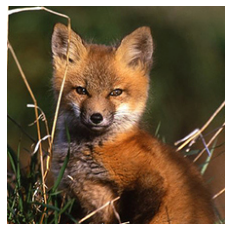

In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return


# def get_features(x, model):
#     x = torch.tensor(img)

#     # make it a batch-like
#     x = x.unsqueeze(dim=0)
#     x = torch.einsum('nhwc->nchw', x)
# #     print("print x shape before it is fed to the model")
# #     print(x.shape)

#     # run MAE
# #     loss, y, mask = model(x.float(), mask_ratio=0.75)
# #     z = model(x.float(), mask_ratio=1)
#     z = model(x.float()).detach().numpy()
#     print("z features shape", z.shape)
#     return z
# #     y = model.unpatchify(y)
# #     y = torch.einsum('nchw->nhwc', y).detach().cpu()




imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [2]:
# import argparse

# import torch
import torch.nn as nn
from model import Model

class Net(nn.Module):
    def __init__(self, num_class, pretrained_path):
        super(Net, self).__init__()

        # encoder
        model = Model()#.cuda()
        model = nn.DataParallel(model)
        model.load_state_dict(torch.load(pretrained_path))

        self.f = model.module.f
        # classifier
        self.fc = nn.Linear(2048, num_class, bias=True)

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.fc(feature)
        return feature #out
    
def get_features(model,img):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)
    
    extracted_features = None
    with torch.no_grad():
        extracted_features = model(x.float())
    extracted_features = extracted_features.numpy()
    print("z features shape", extracted_features.shape)
    return extracted_features    



# def get_features(x, model):
#     x = torch.tensor(img)

#     # make it a batch-like
#     x = x.unsqueeze(dim=0)
#     x = torch.einsum('nhwc->nchw', x)
# #     print("print x shape before it is fed to the model")
# #     print(x.shape)

#     # run MAE
# #     loss, y, mask = model(x.float(), mask_ratio=0.75)
# #     z = model(x.float(), mask_ratio=1)
#     z = model(x.float()).detach().numpy()
#     print("z features shape", z.shape)
#     return z



    
model_path='ipirm/model_400.pth' 
num_classes = 10
model = Net(num_class=num_classes, pretrained_path=model_path)#.cuda()
model.eval()
# for param in model.f.parameters():
#     param.requires_grad = False
# model = nn.DataParallel(model)

get_features(model, img)

z features shape (1, 2048)


array([[0.01070181, 0.07400144, 0.00194098, ..., 0.00429431, 0.04932709,
        0.5451305 ]], dtype=float32)